In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [0]:
INIT_LR = 1e-4
EPOCHS = 4
BS = 32

In [0]:
imagePaths = list(paths.list_images("drive/My Drive/Dataset"))
data = []
labels = []

In [0]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

In [10]:
len(data)

1484

In [0]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [0]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(96, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')])
# for layer in baseModel.layers:
    # layer.trainable = False
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,epochs=EPOCHS)
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))




Epoch 1/4
37/37 [==============================] - 18s 475ms/step - loss: 0.6332 - accuracy: 0.7117 - val_loss: 0.3396 - val_accuracy: 0.9192
Epoch 2/4
37/37 [==============================] - 16s 434ms/step - loss: 0.3442 - accuracy: 0.8606 - val_loss: 0.1895 - val_accuracy: 0.9327
Epoch 3/4
37/37 [==============================] - 16s 436ms/step - loss: 0.3075 - accuracy: 0.8805 - val_loss: 0.1845 - val_accuracy: 0.9529
Epoch 4/4
37/37 [==============================] - 16s 436ms/step - loss: 0.2682 - accuracy: 0.9082 - val_loss: 0.1429 - val_accuracy: 0.9529
              precision    recall  f1-score   support

   with_mask       0.96      0.96      0.96       158
without_mask       0.95      0.95      0.95       139

    accuracy                           0.95       297
   macro avg       0.95      0.95      0.95       297
weighted avg       0.95      0.95      0.95       297



In [0]:
model.save("drive/My Drive/custom_model_gpu.model", save_format="h5")

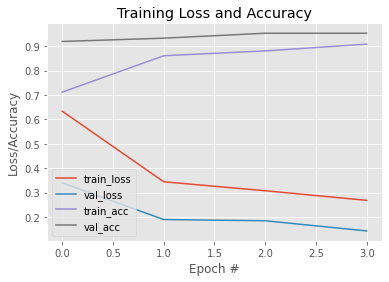

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("drive/My Drive/visualisation.png")


In [20]:
from tensorflow.keras.models import load_model
EPOCHS = 100
model = load_model("drive/My Drive/mask_detector.model")
# for layer in baseModel.layers:
    # layer.trainable = False
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,epochs=EPOCHS)
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
37/37 [==============================] - 16s 435ms/step - loss: 0.2416 - accuracy: 0.9039 - val_loss: 0.1251 - val_accuracy: 0.9630
Epoch 2/100
37/37 [==============================] - 16s 437ms/step - loss: 0.2452 - accuracy: 0.9195 - val_loss: 0.1164 - val_accuracy: 0.9630
Epoch 3/100
37/37 [==============================] - 16s 434ms/step - loss: 0.2191 - accuracy: 0.9203 - val_loss: 0.1159 - val_accuracy: 0.9663
Epoch 4/100
37/37 [==============================] - 16s 434ms/step - loss: 0.2171 - accuracy: 0.9255 - val_loss: 0.0968 - val_accuracy: 0.9697
Epoch 5/100
37/37 [==============================] - 16s 433ms/step - loss: 0.2224 - accuracy: 0.9229 - val_loss: 0.1084 - val_accuracy: 0.9663
Epoch 6/100
37/37 [==============================] - 16s 435ms/step - loss: 0.1904 - accuracy: 0.9377 - val_loss: 0.0934 - val_accuracy: 0.9663
Epoch 7/100
37/37 [==============================] - 16s 434ms/step - loss: 0.1887 - a

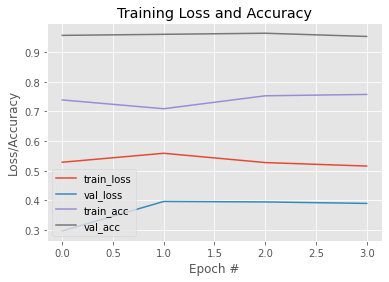

In [39]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("drive/My Drive/visualisation.png")


In [0]:
model.save("drive/My Drive/custom_model_gpu.model", save_format="h5")